In [8]:
import os
import numpy as np
import pandas as pd
from glob import glob
from sfkinetics import PopData, TransitionFitting
from scipy.optimize import curve_fit

In [77]:
bootstrap_iterations = 20
bootstrap_traces = 2000

In [78]:
data = {int(os.path.basename(f)[:2]) : np.genfromtxt(f, delimiter=',') for f in glob("../data/A/idealized_traces/*uM.csv")}

In [79]:
def line_func(x, a, b):
    return a * x + b

In [80]:
fit_results = [] 
for i in range(bootstrap_iterations):
    c_df = []
    for C, ar in data.items():
        popdata = PopData(ar[np.random.choice(ar.shape[0], bootstrap_traces, replace=True)])
        tf = TransitionFitting(popdata, t1=4.85, t2=25.4, t3=35, time_margin=.1)
        tf.k['C'] = C
        tf.k['i'] = i
        
        if tf.k.koff > 8:
            print("fitting issue")
            tf.ggplot().save(f"{C:02d}_{i:03d}.png")
        
        c_df.append(tf.k)
    
    c_df = pd.DataFrame(c_df)

    # now find kon and kd
    koff = c_df.koff.mean()
    c_df["<koff>"] = koff
    kon = curve_fit(lambda x, a: line_func(x, a, koff), c_df.C, c_df.kobs, p0=[0])[0][0]
    c_df['kon'] = kon
    c_df['kd'] = koff/kon
    fit_results.append(c_df)
    
df = pd.concat(fit_results)
df

,t1,A1,kobs,t2,A2,koff,C,i,<koff>,kon,kd
0,4.860277,0.048337,0.780031,25.799208,-0.038557,0.809922,2.0,0.0,0.496852,0.084329,5.891797
1,4.924023,0.052881,1.026079,25.713960,-0.043384,0.466283,4.0,0.0,0.496852,0.084329,5.891797
2,4.825529,0.060431,1.113072,25.656438,-0.060492,0.646086,6.0,0.0,0.496852,0.084329,5.891797
3,4.968036,0.078984,1.030028,26.163849,-0.094114,0.260632,8.0,0.0,0.496852,0.084329,5.891797
4,4.964436,0.079903,1.287498,26.096297,-0.106720,0.301335,10.0,0.0,0.496852,0.084329,5.891797
...,...,...,...,...,...,...,...,...,...,...,...
0,5.421798,0.057224,0.191896,25.869199,-0.026623,0.714080,2.0,19.0,0.459451,0.096794,4.746684
1,4.965914,0.054415,1.032975,25.412113,-0.046495,0.530328,4.0,19.0,0.459451,0.096794,4.746684
2,4.737743,0.062653,1.810939,26.058447,-0.073785,0.435105,6.0,19.0,0.459451,0.096794,4.746684
3,4.901649,0.082113,1.361992,25.848221,-0.083665,0.331236,8.0,19.0,0.459451,0.096794,4.746684


In [81]:
from plotnine import *

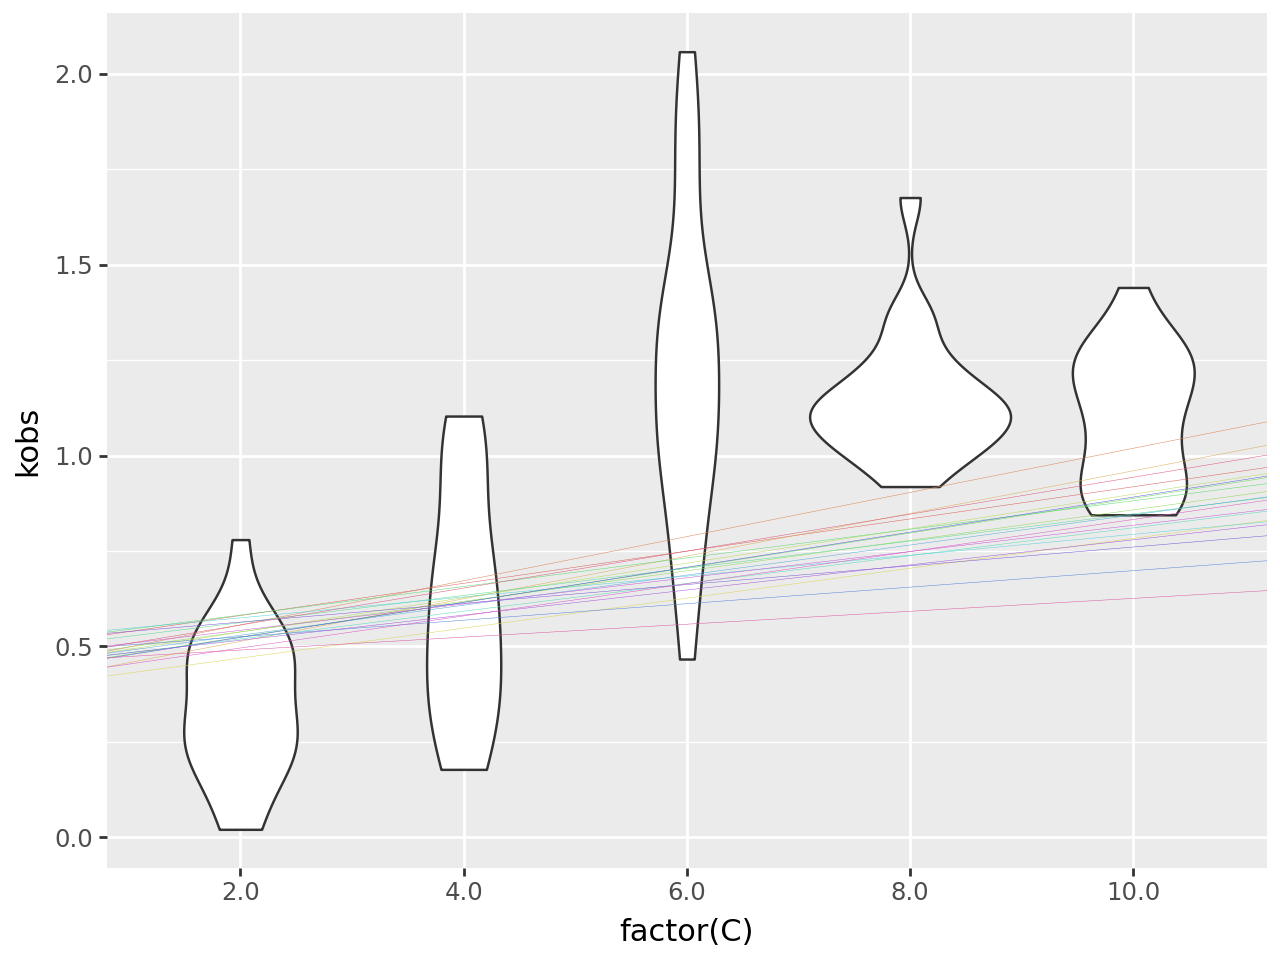

In [82]:
(ggplot(df)
  + aes(x = "factor(C)", y="kobs", color='factor(i)', group='C')
  + geom_violin()
  + geom_abline(aes(slope = 'kon', intercept='<koff>', color='factor(i)'), size=0.1)
  + guides(color = False)
 )

In [83]:
print(f"{df.kon.mean():03f} +- {df.kon.std():03f}")

0.076863 +- 0.020494


In [84]:
print(f"{df.kd.mean():03f} +- {df.kd.std():03f}")

6.599396 +- 2.557545
